In [26]:
# import the usual
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from ipywidgets import interact, fixed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

Here, we put the csv files into dataframe and we try to fit them into X and Y

In [27]:
df_attendance = pd.read_csv('attendance.csv')
df_games = pd.read_csv('games.csv')

excludeYears = [2000, 2001]

# Removes any rows containing a null value from the datasets
df_attendance = df_attendance[~df_attendance['year'].isin(excludeYears)]
df_attendance = df_attendance.dropna()
droppit = ['team', 'total', 'home', 'away']
df_attendance = df_attendance.drop(droppit, axis=1)
df_attendance.rename(columns={'team_name': 'home_team_name'}, inplace=True)
df_attendance['week'] = df_attendance['week'].astype(int)
df_attendance['weekly_attendance'] = df_attendance['weekly_attendance'].astype(int)

df_games = df_games[~df_games['year'].isin(excludeYears)]
droppa = ['home_team', 'away_team', 'tie', 'home_team_city', 'away_team_city']
exclude_weeks = ['WildCard', 'Division', 'ConfChamp', 'SuperBowl']
df_games = df_games.drop(droppa, axis=1)
df_games = df_games[~df_games['week'].isin(exclude_weeks)]
df_games = df_games.dropna()
df_games['week'] = df_games['week'].astype(int)

right = ['year', 'week', 'home_team_name']
df_result = df_attendance.merge(df_games, on=right)
to_convert_categorical = ['home_team_name', 'winner', 'day', 'away_team_name']

df_result[to_convert_categorical] = df_result[to_convert_categorical].astype('category')
df_result = df_result.drop('date', axis=1)
df_result = df_result.drop('time', axis=1)

df_result_numerical = df_result.select_dtypes(include=[np.number])

correlation_matrix = df_result_numerical.corr()

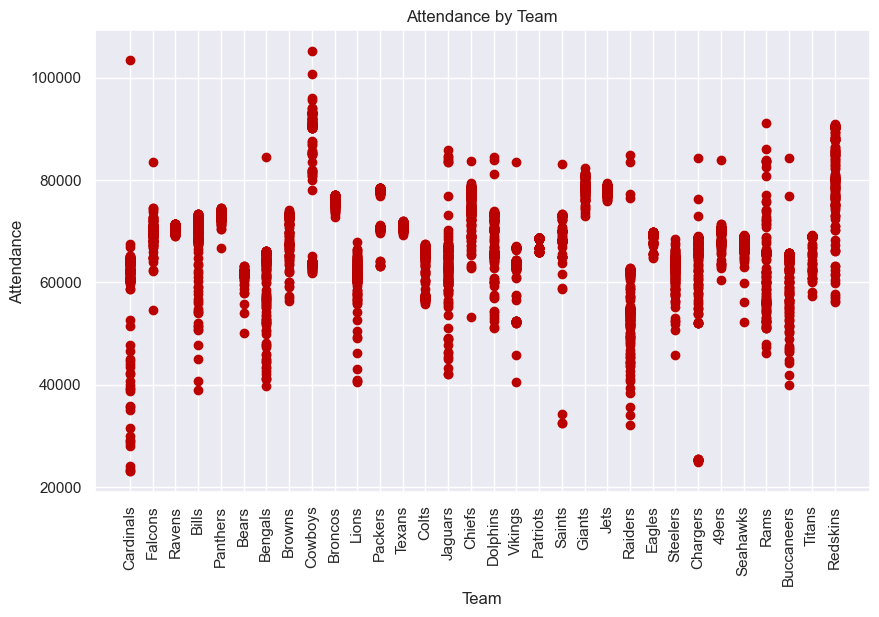

In [28]:
plt.figure(figsize=(10,6))
plt.scatter(df_result['home_team_name'], df_result['weekly_attendance'], color='#BB0000')

plt.xlabel('Team')
plt.ylabel('Attendance')
plt.title('Attendance by Team')
plt.xticks(rotation=90)
plt.tight_layout

plt.show()

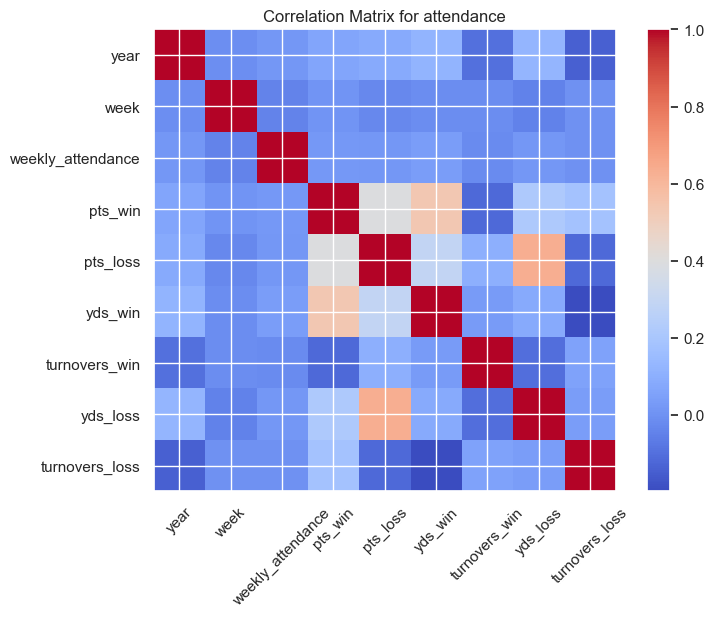

In [29]:
plt.figure(figsize=(8,6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix for attendance")
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()


In [30]:
X = df_result.drop('weekly_attendance', axis=1)
y = df_result['weekly_attendance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
encoded_dfs_train = []
encoded_dfs_test = []
for col in to_convert_categorical:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_train = encoder.fit_transform(X_train[[col]])
    encoded_test = encoder.transform(X_test[[col]])
    encoded_dfs_train.append(pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col])))
    encoded_dfs_test.append(pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col])))

X_train_encoded = pd.concat([X_train.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_train, axis=1)
X_test_encoded = pd.concat([X_test.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_test, axis=1)

/Users/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sp

In [32]:
model = SVR()

In [33]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.2, 0.5],
    'gamma': ['auto', 'scale', 0.1, 0.5, 1.0],    # Include 'auto' and 'scale' and other float values
    'degree': [2, 3, 4, 5],                       # Values for the 'degree' parameter for polynomial kernel
    'coef0': [0.0, 0.1, 0.5, 1.0],                # Values for the 'coef0' parameter for poly and sigmoid kernels
    'shrinking': [True, False],                    # Boolean values for 'shrinking'
    'tol': [1e-3, 1e-4, 1e-5]
}

In [34]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [35]:
# grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=3)
search = RandomizedSearchCV(model, param_grid, scoring=scorer, cv=3)
grid_result = search.fit(X_train_encoded, y_train)

In [36]:
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'tol': 0.001, 'shrinking': False, 'kernel': 'poly', 'gamma': 'auto', 'epsilon': 0.2, 'degree': 2, 'coef0': 1.0, 'C': 0.1}


In [37]:
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_encoded)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error: ", mae)
print("R2 Score: ", r2_score)

Mean Squared Error: 49659939.358026884
Mean Absolute Error:  3894.8574526430625
R2 Score:  0.3907343140394304


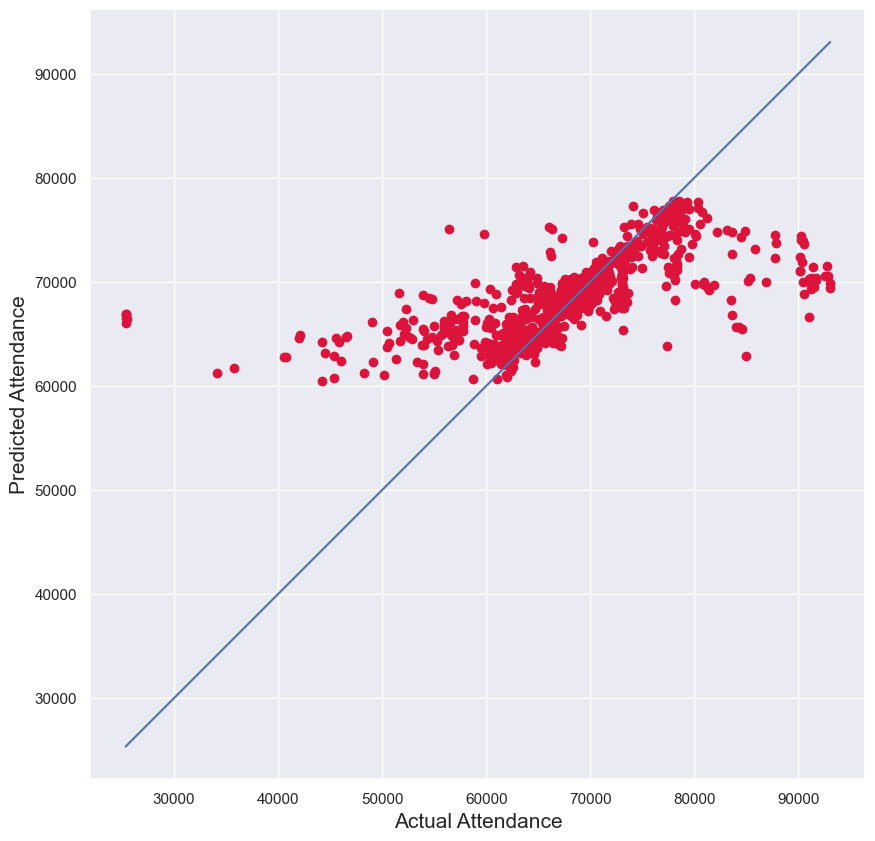

In [38]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Attendance', fontsize=15)
plt.ylabel('Predicted Attendance', fontsize=15)
plt.axis('equal')
plt.show()